# Qiskit Patterns Basics

A Qiskit pattern is a general framework for breaking down domain-specific problems and contextualizing required capabilities in stages. This allows for the seamless composability of new capabilities developed by IBM Quantum™ researchers (and others) and enables a future in which quantum computing tasks are performed by powerful heterogenous (CPU/GPU/QPU) computing infrastructure. Blocks or groups of blocks perform the steps of a pattern, with the Qiskit SDK providing an important foundational layer, supported by other tools or services developed by IBM Quantum or the quantum open-source community. Qiskit patterns allow domain experts to specify a problem and compose the tooling (blocks) that achieves a Qiskit pattern. That pattern can then be executed locally, through cloud services, or deployed with Qiskit Serverless.

The four steps of a Qiskit pattern are as follows
:

- Map problem to quantum circuits and operators
- Optimize for target hardware
- Execute on target hardware
- Post-process results

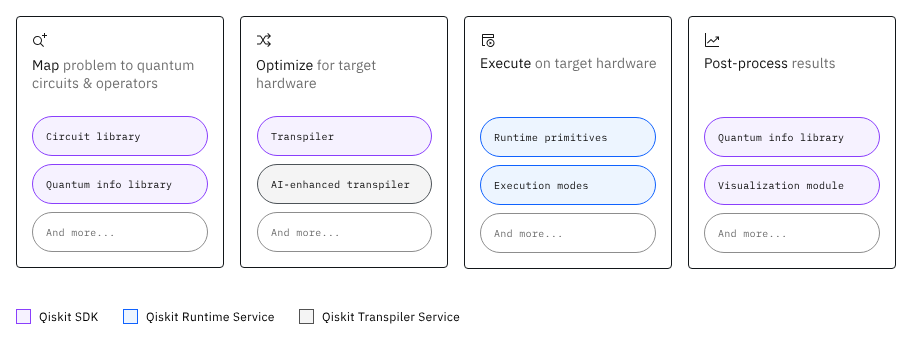

In [5]:
!pip install qiskit
!pip install qiskit-ibm-runtime

In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [9]:
# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

When working with quantum circuits in Qiskit, it's important to determine the type of data you want to retrieve after executing the circuit. You can obtain:

1. **Probability Distribution:** Measures the likelihood of different outcomes based
on the states of the qubits.
2. **Expectation Value of an Observable:** Calculates the average value of a specific observable (a property represented mathematically) over the quantum state.

In [10]:
# Set up six different observables.
from qiskit.quantum_info import SparsePauliOp

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

## Step 2. Optimize the circuits and operators

When running quantum circuits on real quantum devices, optimizing the circuits is crucial to reduce errors and noise. Here's a summary of what happens:

**1. Why Optimize?**

* Reduce errors and noise: Shorter circuits (fewer operations) are less prone to errors on real quantum hardware.
*  Match device constraints: Quantum devices have specific native gates (basis gates) and connectivity limits between qubits, so the circuit must align with these constraints.

<br>

**2. How to Optimize?**

* Transpile: This process transforms the circuit to fit the device’s instruction set (its basis gates and qubit connectivity).
* Further optimization: Use optimization passes to simplify the circuit, reducing unnecessary operations and minimizing depth (number of gates).






In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService(channel = "ibm_quantum", token= "c7265fed7685b7289a4b887f364ce471465bf5baa0ccd39cf1b6dc59d11aaaf151e48d7c70d744bc4db47686d0afe863770ac52b5357f7a9f056f825bdc66e76")

backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw(idle_wires=False)

global phase: 7π/4
          ┌────────┐ ┌────┐          ┌──────┐┌──────────┐┌────┐┌─────────┐
q_0 -> 0 ─┤ Rz(-π) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├
         ┌┴────────┴┐├────┤┌────────┐│  Ecr │├─────────┬┘├────┤├─────────┤
q_1 -> 1 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├
         └──────────┘└────┘└────────┘└──────┘└─────────┘ └────┘└─────────┘

## Step 3. Execute using the quantum primitives

**Primitives** in quantum computing, specifically in Qiskit, are simple and easy-to-use tools that help you run quantum circuits and get useful results without dealing with all the complex details of the underlying quantum hardware.

**Sampler **

**Estimator **

In [16]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cwd14ykggr6g008ve5qg


After a job is submitted, you can wait until either the job is completed within your current python instance, or use the job_id to retrieve the data at a later time. (See the section on retrieving jobs for details.)

After the job completes, examine its output through the job's result() attribute.

In [17]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

**Step 4. Analyze the results**

The analyze step in quantum computing typically involves postprocessing results from the quantum job execution.
1. Use post-selection to refine the measurement results by discarding invalid or noisy data.
2. Apply circuit knitting to break complex circuits into smaller ones if needed, allowing for more scalable computations.
3. Perform measurement error mitigation or zero noise extrapolation (ZNE) to reduce errors.

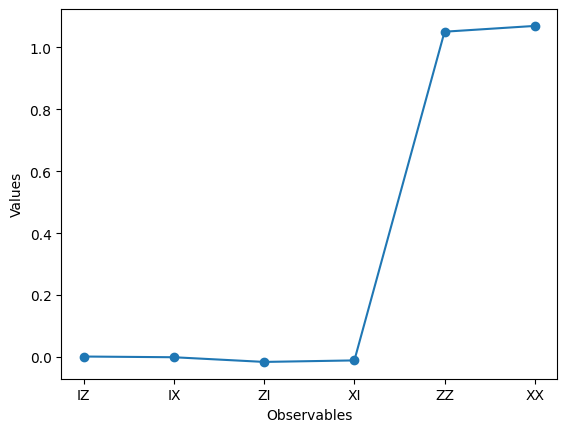

In [18]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()
